# Coursera Course Dataset Analysis

## Introduction
Online learning has transformed education, offering global access to quality courses. Coursera provides a variety of courses, specializations, and certificates from top universities and institutions.

In this project, I will analyze the Coursera Course Dataset to uncover key insights about *course ratings*, *difficulty levels*, *certification types*, *enrollment scale*, *course organizations*. The main objectives of this analysis are:

1. **Understand the structure of the dataset** – Identify key variables and perform initial data cleaning.
2. **Explore course characteristics** – Analyze trends in course difficulty, registration frequency, and ratings.
3. **Evaluate certification types** – Determine what certification documents prevail on Coursera.
4. **Identify top institutions** – Discover which universities or organizations offer the most highly rated courses.
5. **Uncover relationships** – Examine how factors like course enrollment scale, difficulty level, and certification type influence ratings.

Using data visualization and EDA, I will **offer insights into the key factors that impact a program’s popularity and guide learners in making informed course selections**. I will utilise Pandas,Numpy for data manipulation and Seaborn, Matplotlib, Plotly libraries for lucid, efficacious visualization.


## 1. Data Loading & Cleaning
Before conducting a proper data exploration it is crucial perform data loading and cleaning by **uploding the dataset**, **handling missing values and duplicates** to ensure the the clarity and reliability of the dataset.

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import cufflinks as cf
from langdetect import detect
import seaborn as sns
import plotly.express as px
import sys
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
cf.go_offline()


In [146]:
courses = pd.read_csv("coursera_data.csv")

In [147]:
courses.head()

Unnamed: 0                                       course_title  \
0         134  (ISC)² Systems Security Certified Practitioner...   
1         743  A Crash Course in Causality:  Inferring Causal...   
2         874                     A Crash Course in Data Science   
3         413                            A Law Student's Toolkit   
4         635                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty course_students_enrolled  
0          Beginner                     5.3k  
1      Intermediate                      17k  
2             Mixed                     130k  
3             Mixed                      91k  
4             Mixed                     320k

In [148]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                891 non-null    int64  
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    object 
 4   course_rating             891 non-null    float64
 5   course_difficulty         891 non-null    object 
 6   course_students_enrolled  891 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 48.9+ KB


In [149]:
courses.duplicated().sum()

np.int64(0)

In [150]:
courses.rename(columns={"Unnamed: 0": "ID"}, inplace=True)

In [151]:
# to brush up the course_students_enrolled column
courses["course_students_enrolled"] = courses["course_students_enrolled"].str.replace(
    "m", "000k"
)
courses["course_students_enrolled"] = courses["course_students_enrolled"].str.replace(
    "k", ""
)

# converting values to float
courses["course_students_enrolled"] = courses["course_students_enrolled"].astype(float)


 After implementing data loading and cleaning there were no missing values nor duplicates found. 

## 2. Understanding the Dataset
Understanding the dataset's structure involves checking the **number of rows and columns**, identifying **categorical and numerical features**, and addressing **outliers** to prevent distortions. This will guarantee a solid foundation for meaningful analysis.


In [152]:
print(
    f"The shape of the dataset: {courses.shape[0]} rows and {courses.shape[1]} columns"
)

The shape of the dataset: 891 rows and 7 columns


In [153]:
print(f"The number of observations in the dataset: {courses.shape[0]}")

The number of observations in the dataset: 891


 There are 6 disparate features both categorical and numerical that illustrate the difference across various courses.

 **NUMERICAL FEATURES**:
1. **course_rating** - course rank among other programs.
2. **ID** - course identification number.

**CATEGORICAL FEATURES**:
1. **course_organization** - title of institution providing the course.
2. **course_difficulty** - decribes the level of the program(e.g., Beginner, Intermediate, etc..)
3. **course_Certification_type** - category of certification(e.g., COURSE,SPECIALIZATION, etc..)
4. **course_students_enrolled** - number of students registered for taking the course(measured in thousands).

### Identifying outliers
This dataset includes only two numerical categories: "ID" and "course_rating". Although "ID" column is created just for the identification case and doesn't hold any siginificant value. 

Moreover, even though feature "course_students_enrolled" is categorical it is beneficial to transform it to numerical in order to evaluate numbers of enrolled students on a particular course.


In [154]:
def identify_outliers(col_name: str) -> pd.DataFrame:
    """
    By performing simple statistical operations computes z-score in order to find extreme values among numerical features' data and print them out.
    :param col_name: name of the numerical attribute
    :type col_name: str
    :return: DataFrame of outliers for a specific numerical category.
    :rtype: pandas Dataframe
    """
    print(f"for {col_name} column: ")

    # computing mean and standard deviation
    mean = courses[col_name].mean()
    std_dev = courses[col_name].std()

    # calculate z_score
    courses["z_score"] = (courses[col_name] - mean) / std_dev

    # identifying outliers
    outliers = (courses[np.abs(courses["z_score"]) > 3]).round(2)
    print(f"total number of outliers: {outliers.shape[0]}")
    outliers = outliers.reset_index(drop=True)
    return outliers

 As a result, the only outliers might be found among "course_rating" and "course_students_enrolled" data.

In [155]:
columns = courses[["course_rating", "course_students_enrolled"]]
for col in columns:
    identify_outliers(col)

for course_rating column: 
total number of outliers: 7
for course_students_enrolled column: 
total number of outliers: 20


## 3. Course titles and establishments'names

Investigating this feature will lead to gaining insight into the **number of courses and unique institutions that are more popular**, **English-based** programs as well as **non-English** on Coursera website.

In [156]:
courses_titles = courses["course_title"]

In [157]:
course_establishments = courses["course_organization"]

In [158]:
print(f"Total of unique instituions' titles: {course_establishments.nunique()}")

Total of unique instituions' titles: 154


##### Examination of English and non-English courses

In [159]:
def is_english() -> tuple:
    """
    Returns two lists of programs that are most likely taught in English and those that are not.
    :return: tuple of two lists - english_courses and non_english_courses
    :rtype: tuple
    """
    english_courses = []
    non_english_courses = []

    # Detecting English and non-english titles while appending lists for each category
    for name in courses_titles:
        try:
            if detect(name) == "en":
                english_courses.append(name)
            else:
                non_english_courses.append(name)
        except:
            # If language detection fails, classify as non-English for safety
            non_english_courses.append(name)

    return english_courses, non_english_courses

In [160]:
english_courses, non_english_courses = is_english()
print(f"Number of courses taught in English: {len(english_courses)}")
print(f"Number of courses not taught in English: {len(non_english_courses)}")

Number of courses taught in English: 721
Number of courses not taught in English: 170


##### Assessment of foundations with abundant number of courses

In [161]:
most_popular_establishments = course_establishments.value_counts()
most_popular_establishments.head(10)

course_organization
University of Pennsylvania                    59
University of Michigan                        41
Google Cloud                                  34
Johns Hopkins University                      28
Duke University                               28
University of California, Irvine              27
IBM                                           22
University of Illinois at Urbana-Champaign    22
University of California, Davis               21
University of Colorado Boulder                19
Name: count, dtype: int64

C:\Users\marii\AppData\Local\Temp\ipykernel_18412\20402450.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 0, 'Number of courses')

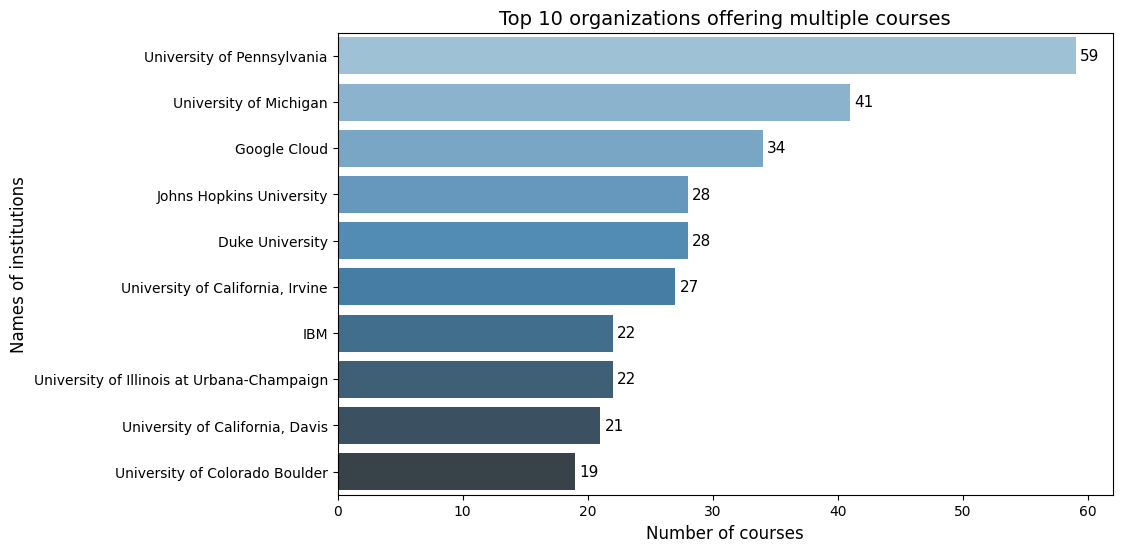

In [162]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=most_popular_establishments.values[:10],
    y=most_popular_establishments.index[:10],
    palette="Blues_d",
)
for container in ax.containers:
    ax.bar_label(container, fontsize=11, padding=3)
plt.title("Top 10 organizations offering multiple courses", fontsize=14, color="black")
plt.ylabel("Names of institutions", fontsize=12, color="black")
plt.xlabel("Number of courses", fontsize=12, color="black")

### *Institutions categories*

##### Courses equipped by universities:

In [163]:
university_taught = courses[courses["course_organization"].str.contains("Uni")]
print(
    f"There are {university_taught["ID"].count()} programs distributed by universities."
)

There are 643 programs distributed by universities.


##### Courses allocated by other establishments:

In [164]:
institutions_taught = courses[~courses["course_organization"].str.contains("Uni")]
print(
    f"There are {institutions_taught["ID"].count()} programs furnished by other corporations."
)

There are 248 programs furnished by other corporations.


### **Key Insights**:
* There is a number of foundations delivering multiple **programs both in English and non-English languages** on Coursera.
* The majority of courses are offered by universities rather than other entities.
* Top 10 foundations granting numerous programs include prominent foundations such as Google Cloud, IBM which speaks for **Coursera's strong industry partnerships**. These organizations, alongside leading universities like the University of Pennsylvania, the University of Michigan, and Johns Hopkins University, contribute to a **diverse range of educational offerings**. 

## 4. Course Difficulty levels and Rating Scale

Evaluation of these features will allow to discover distinct course **difficulty categories**, **basic statistics** among courses ratings and **relationship between course complexity levels and rating**.

In [165]:
print(f"Course complexity level categories: {courses["course_difficulty"].unique()}")

Course complexity level categories: ['Beginner' 'Intermediate' 'Mixed' 'Advanced']


##### Difficulty levels distribution across programs

In [166]:
difficulty_levels_distribution = courses["course_difficulty"].value_counts()
difficulty_levels_distribution

course_difficulty
Beginner        487
Intermediate    198
Mixed           187
Advanced         19
Name: count, dtype: int64

##### Rating property simple statistics

In [167]:
courses["course_rating"].describe()

count    891.000000
mean       4.677329
std        0.162225
min        3.300000
25%        4.600000
50%        4.700000
75%        4.800000
max        5.000000
Name: course_rating, dtype: float64

In [185]:
colors = ["#0000FF", "#00008B", "#4682B4", "#1E90FF"]
fig = px.box(
    courses,
    x="course_difficulty",
    y="course_rating",
    color="course_difficulty",
    color_discrete_sequence=colors,
)
fig.update_layout(
    title={
        "text": "Distribution of Score Ratings by Difficulty",
        "font": {"size": 18, "weight": "bold"},
        "x": 0.5,
    },
    height=500,
    width=800,
    xaxis_title={"text": "Difficulty Levels", "font_size": 16},
    yaxis_title={"text": "Course Rating Scores", "font_size": 16},
    xaxis=dict(tickfont=dict(size=14)),
)

##### Identifiyng highest rating courses

In [169]:
highest_rate_programs = courses[
    courses["course_rating"] > courses["course_rating"].mean()
]
print(
    f"There are {highest_rate_programs["ID"].count()} programs with rating score above average."
)

There are 577 programs with rating score above average.


##### *Identifying outliers among course_rating feature*

In [170]:
outliers_course_rating = identify_outliers("course_rating")
outliers_course_rating[
    ["ID", "course_title", "course_rating", "course_students_enrolled", "z_score"]
]

for course_rating column: 
total number of outliers: 7


ID                                       course_title  course_rating  \
0  767  How To Create a Website in a Weekend! (Project...            3.3   
1  609                     How to Start Your Own Business            4.1   
2  659    Introduction to Trading, Machine Learning & GCP            4.0   
3  352  Machine Learning and Reinforcement Learning in...            3.7   
4  178                       Machine Learning for Trading            3.9   
5  873              Mathematics for Machine Learning: PCA            4.0   
6  779                     iOS App Development with Swift            3.9   

   course_students_enrolled  z_score  
0                     140.0    -8.49  
1                      34.0    -3.56  
2                      13.0    -4.18  
3                      29.0    -6.02  
4                      15.0    -4.79  
5                      33.0    -4.18  
6                      76.0    -4.79

The majority of these outliers are observed in fields like programming, business, and data analysis, with scores falling below the average.

### **Key Insights**:
* There are four diverse complexity levels found among Coursera courses.
* **Maximum rating reaches 5**, minimum - 3.3 with average merely above 4.67.
* **Highest-rate programs** are predominantly present among **"Beginner" and "Intermediate"** level courses.

## 5. Course certification categories 

Exploration of possible certification categories allows to gain awareness of most prevalent course **completion documents**, their **rate among dinstict establishments** that might help evaluate the most widespread diplomas on Coursera.

In [171]:
courses["course_Certificate_type"].value_counts()

course_Certificate_type
COURSE                      582
SPECIALIZATION              297
PROFESSIONAL CERTIFICATE     12
Name: count, dtype: int64

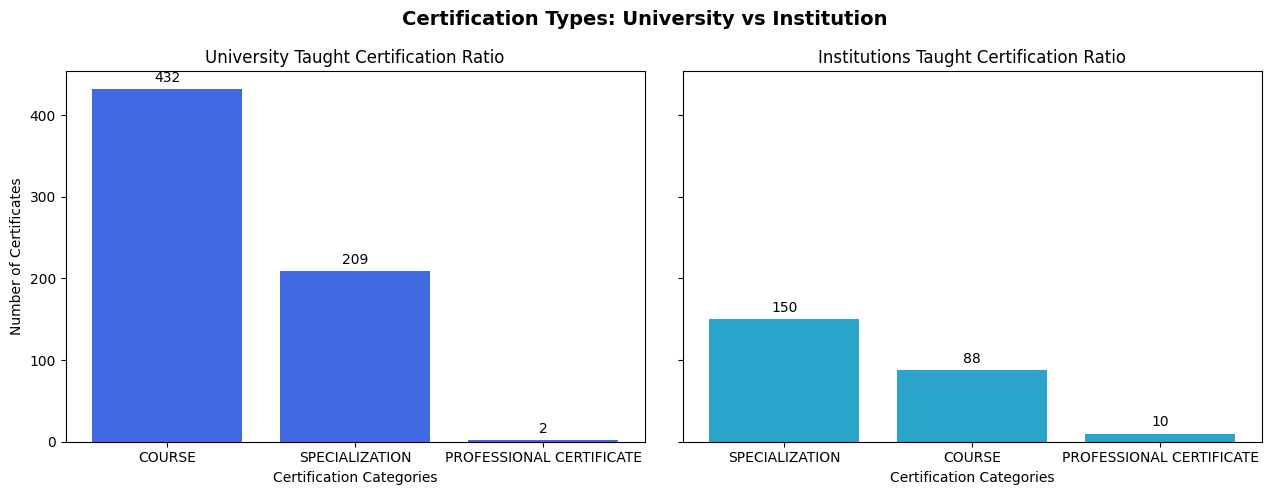

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

fig.suptitle(
    "Certification Types: University vs Institution", fontsize=14, weight="bold"
)

uni_bars = axes[0].bar(
    university_taught["course_Certificate_type"].unique(),
    university_taught["course_Certificate_type"].value_counts(),
    color="royalblue",
)
axes[0].set_title("University Taught Certification Ratio")
axes[0].set_xlabel("Certification Categories")
axes[0].set_ylabel("Number of Certificates")
axes[0].bar_label(uni_bars, fmt="%d", padding=3)

inst_bars = axes[1].bar(
    institutions_taught["course_Certificate_type"].unique(),
    institutions_taught["course_Certificate_type"].value_counts(),
    color="#2aa4c9",
)
axes[1].set_title("Institutions Taught Certification Ratio")
axes[1].set_xlabel("Certification Categories")
axes[1].bar_label(inst_bars, fmt="%d", padding=3)
plt.tight_layout()

### **Key Insights**
* There are three types of evaluation documents awarded to students upon completing a program: **Course**, **Specialization**, and **Professional Certificate**, with course certificates being the most common. 
* Universities tend to issue more course and specialization certificates compared to non-university institutions, while other organizations issue more professional certificates than universities.

## 6. Course Registration Rate VS Complexity Levels VS Rating Scores

Analysis of these three attributes will help getting a better understanding of **simple computations of enrollment rate**, establishing a **connection between registration and rating scores traits by difficulty levels** showcassing it's impact on courses' **popularity** among learners.

##### Registration scale basic statistics

In [173]:
courses["course_students_enrolled"].describe()

count    891.000000
mean      81.021773
std      108.548736
min        1.300000
25%       17.000000
50%       42.000000
75%       97.500000
max      830.000000
Name: course_students_enrolled, dtype: float64

##### Identifiyng highest enrollment courses

In [174]:
highest_enrollment_courses = courses[
    courses["course_students_enrolled"] > courses["course_students_enrolled"].mean()
]
print(
    f"There are {highest_enrollment_courses["ID"].count()} programs with attendance rate above average."
)

There are 263 programs with attendance rate above average.


Text(0.5, 1.0, 'Course Ratings vs. Student Enrollment')

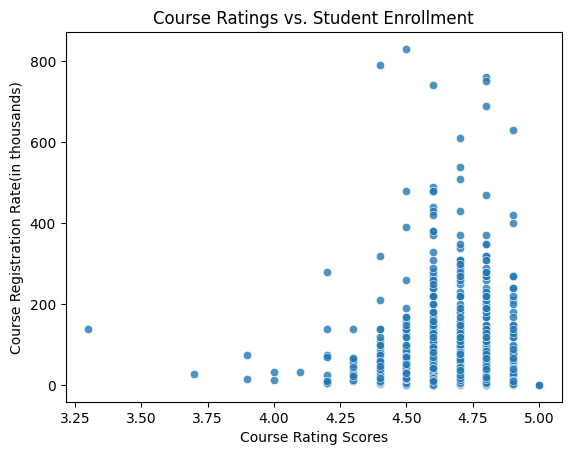

In [175]:
plt.Figure(figsize=(14, 12))
sns.scatterplot(
    x=courses["course_rating"], y=courses["course_students_enrolled"], alpha=0.8
)
plt.xlabel("Course Rating Scores", fontdict={"fontsize": 10, "color": "black"})
plt.ylabel(
    "Course Registration Rate(in thousands)",
    fontdict={"fontsize": 10, "color": "black"},
)
plt.title(
    "Course Ratings vs. Student Enrollment", fontdict={"fontsize": 12, "color": "black"}
)

In [176]:
fig = px.scatter(
    courses,
    x="course_students_enrolled",
    y="course_rating",
    hover_name="course_difficulty",
    color="course_difficulty",
    size="course_students_enrolled",
    size_max=60,
    log_x=True,
    symbol="course_difficulty",
)
fig.update_layout(
    title={
        "text": "Relationships Between Course Features by Difficulty",
        "font": {"size": 18, "weight": "bold"},
        "x": 0.5,
    },
    xaxis_title={"text": "Course Attendance(in thousands)", "font_size": 16},
    yaxis_title={"text": "Course Rating Scores", "font_size": 16},
)

##### *Identifying outliers among enrollment rate of users*

In [177]:
outliers_students_enrolled = identify_outliers("course_students_enrolled")
outliers_students_enrolled[
    ["ID", "course_title", "course_rating", "course_students_enrolled", "z_score"]
]

for course_students_enrolled column: 
total number of outliers: 20


ID                                       course_title  course_rating  \
0    63                          Academic English: Writing            4.7   
1    26                   Applied Data Science with Python            4.5   
2     7                               Business Foundations            4.7   
3    44                                     Career Success            4.4   
4    13                                       Data Science            4.5   
5    15                  Data Science: Foundations using R            4.6   
6     5                                      Deep Learning            4.8   
7   175                     English for Career Development            4.8   
8    38   Excel to MySQL: Analytic Techniques for Business            4.6   
9    14                                  Financial Markets            4.8   
10  385                            Grammar and Punctuation            4.7   
11    0                                   IBM Data Science            4.6   
12   36          Improve Your English Communication Skills            4.7   
13   62                  Neural Networks and Deep Learning            4.9   
14   31  Project Management & Other Tools for Career De...            4.6   
15  111                             Python Data Structures            4.9   
16  317                                      R Programming            4.6   
17  334  Speak English Professionally: In Person, Onlin...            4.6   
18   40  Successful Negotiation: Essential Strategies a...            4.8   
19  243                       The Data Scientist’s Toolbox            4.6   

    course_students_enrolled  z_score  
0                      540.0     4.23  
1                      480.0     3.68  
2                      510.0     3.95  
3                      790.0     6.53  
4                      830.0     6.90  
5                      740.0     6.07  
6                      690.0     5.61  
7                      760.0     6.26  
8                      490.0     3.77  
9                      470.0     3.58  
10                     430.0     3.21  
11                     480.0     3.68  
12                     610.0     4.87  
13                     630.0     5.06  
14                     440.0     3.31  
15                     420.0     3.12  
16                     480.0     3.68  
17                     430.0     3.21  
18                     750.0     6.16  
19                     420.0     3.12

These outliers are identified based on student engagement metrics, where both ratings and enrollment exceed the average in fields such as data science, programming, business management, English, and finance, indicating their popularity among students.

### **Key Insights**:
* The top enrollment rate achieves the number of 830K, the minority - 1.30K while the average registration score is slightly above 81K.
* Data mapping("Course Ratings vs. Student Enrollment") clearly indicates that **higher-ranked programs tend to attract more learners**.
* Graphical data analysis("Relationships Between Course Features by Difficulty") shows that **courses with the largest enrollment figure are mostly are meant for entry-level,general and middle-level learners** which also have the highest ratings.

## 7. Most popular programs examination

Assessing the most popular and favorable courses on platforms like Coursera can grant valuable insights into **emerging trends and areas of growing interest** in various fields. By analyzing course popularity, it's possible to gain a better **understanding of what skills, subjects, and industries are currently in high demand by learners**.

In [178]:
most_popular_courses = courses[
    (courses["course_rating"] > courses["course_rating"].mean())
    & (courses["course_students_enrolled"] > courses["course_students_enrolled"].mean())
]
print(f"There are {most_popular_courses["ID"].count()} programs.")
most_popular_courses = most_popular_courses.sort_values(
    by=["course_rating", "course_students_enrolled"], ascending=False
).head(10)

There are 172 programs.


### 10 **most** favorable courses on Coursera

Text(0.5, 0, 'Number of courses')

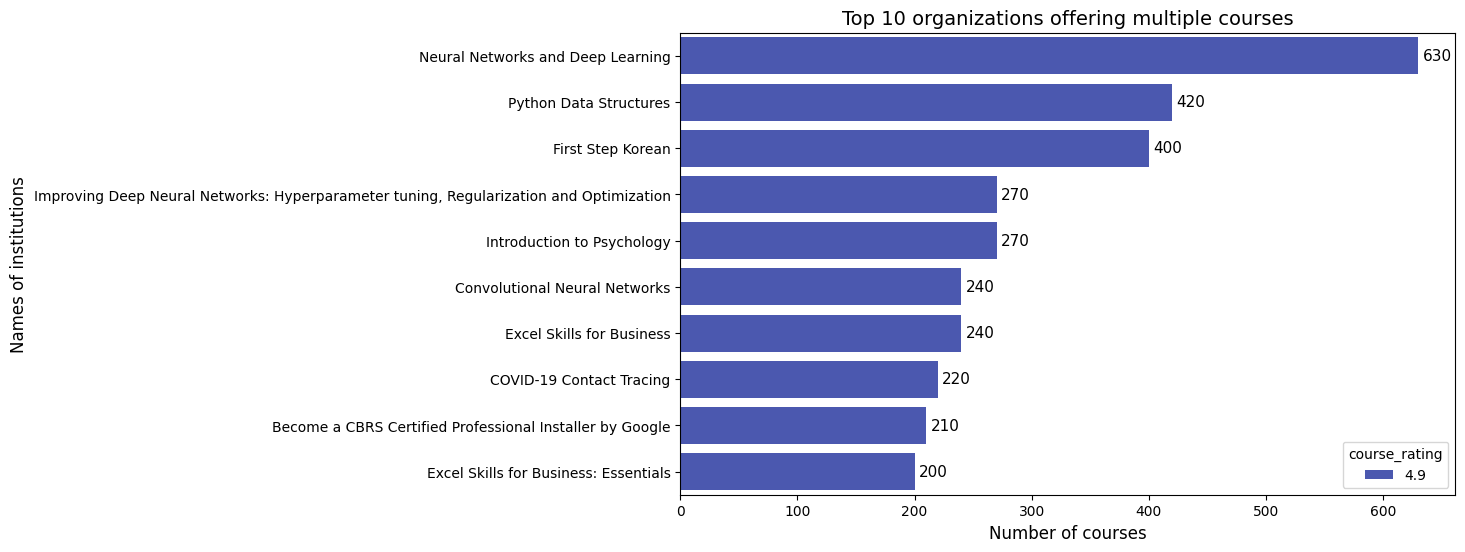

In [179]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y=most_popular_courses["course_title"][:10],
    x=most_popular_courses["course_students_enrolled"][:10],
    palette="coolwarm",
    hue=most_popular_courses["course_rating"],
)
for container in ax.containers:
    ax.bar_label(container, fontsize=11, padding=3)
plt.title("Top 10 organizations offering multiple courses", fontsize=14, color="black")
plt.ylabel("Names of institutions", fontsize=12, color="black")
plt.xlabel("Number of courses", fontsize=12, color="black")

### **Key Insights**
* Based on the data representation above, the most popular programs with the highest enrollment and rating scores are primarily focused on developing skills in fields such as **programming**, learning the **Korean language**, **business** and understanding **COVID-19**. These areas reflect the largest trends on the Coursera platform.

* This popularity may be due to **high industry demand** for technical and business skills, **global relevance** (e.g., COVID-19 and Korean culture), and the **practical value** of these courses for **career advancement**. Additionally, **recognized certifications** and **flexible learning options** make these fields more accessible and appealing to a wide range of learners.

## Overview


**WHAT MAKES A COURSE SUITABLE?**
1. Awareness of the field of interest and personal level.
2. Recognition of course rating and number of enrolled learners.
3. Familiarity with prestige universities, institutions or personally preferenced institution.

Top 10 recommended courses based on rating, enrollment rate for **BEGINNERS**.

In [186]:
def top_programs(level, average_rank):
    """ "
    Returns a DataFrame consisted of top 10 courses for each difficulty level with the ranking above average value.
    :param level: name signifying the difficulty level
    :type level: string
    :param average_rank: average rating of the course based on complexity level
    :type average_rank: int
    :return: pandas DataFrame of 10 top programs for a certain type of learners.
    :rtype: pd.DataFrame
    """
    top_df = highest_rate_programs[
        (highest_rate_programs["course_difficulty"] == level)
        & (highest_rate_programs["course_rating"] > average_rank)
    ]
    top_df = top_df.sort_values(by="course_rating", ascending=False)
    return top_df[
        ["ID", "course_title", "course_rating", "course_Certificate_type"]
    ].head(10)

In [181]:
top_beginner = top_programs("Beginner", 4.68)
top_beginner

ID                                       course_title  course_rating  \
251  789  El Abogado del Futuro: Legaltech y la Transfor...            5.0   
147  890  Compassionate Leadership Through Service Learn...            4.9   
512   29                         Introduction to Psychology            4.9   
98   645                 Boosting Creativity for Innovation            4.9   
99    72  Brand Management: Aligning Business, Brand and...            4.9   
102  688                Bugs 101: Insect-Human Interactions            4.9   
529  741  Introdução aos Princípios e Práticas da Gestão...            4.9   
836  500  Understanding Einstein: The Special Theory of ...            4.9   
124   21                           COVID-19 Contact Tracing            4.9   
250  636                           Egiptología (Egyptology)            4.9   

    course_Certificate_type  
251                  COURSE  
147                  COURSE  
512                  COURSE  
98                   COURSE  
99                   COURSE  
102                  COURSE  
529          SPECIALIZATION  
836                  COURSE  
124                  COURSE  
250                  COURSE

Top 10 recommended courses based on rating, enrollment rate for **INTERMEDIATE** students.

In [182]:
top_intermediate = top_programs("Intermediate", 4.65)
top_intermediate

ID                                     course_title  course_rating  \
432  401                     Infectious Disease Modelling            5.0   
846  638                      Unraveling the Cycling City            4.9   
703  386               Revisão Sistemática e Meta-análise            4.9   
325  851  Formulación y evaluación de proyectos complejos            4.9   
294  218        Excel Skills for Business: Intermediate I            4.9   
754  657                             Stories of Infection            4.9   
235  697                            Discrete Optimization            4.9   
162  207                    Convolutional Neural Networks            4.9   
807  576    The Oral Cavity: Portal to Health and Disease            4.9   
829  438    Troubles du spectre de l'autisme : diagnostic            4.9   

    course_Certificate_type  
432          SPECIALIZATION  
846                  COURSE  
703                  COURSE  
325                  COURSE  
294                  COURSE  
754                  COURSE  
235                  COURSE  
162                  COURSE  
807                  COURSE  
829                  COURSE

Top 10 recommended courses based on rating, enrollment rate for **MIXED** audience.

In [183]:
top_mixed = top_programs("Mixed", 4.71)
top_mixed

ID                                       course_title  course_rating  \
477  421                    Introduction to Classical Music            4.9   
803  587  The Horse Course: Introduction to Basic Care a...            4.9   
472  620                      Introduction to Breast Cancer            4.9   
564    6                                   Machine Learning            4.9   
614  481          More Introduction to Financial Accounting            4.9   
615  652                                      Mountains 101            4.9   
618  784                         Music Business Foundations            4.9   
702  414                   Rethinking International Tax Law            4.9   
779  647                  Systems Thinking In Public Health            4.9   
782  559         Teach English Now! Foundational Principles            4.9   

    course_Certificate_type  
477                  COURSE  
803                  COURSE  
472                  COURSE  
564                  COURSE  
614                  COURSE  
615                  COURSE  
618                  COURSE  
702                  COURSE  
779                  COURSE  
782                  COURSE

Top 10 recommended courses based on rating, enrollment rate for **ADVANCED** learners.

In [184]:
top_advanced = top_programs("Advanced", 4.6)
top_advanced

ID                                       course_title  course_rating  \
600  214                               Medical Neuroscience            4.9   
514  729                  Introduction to Self-Driving Cars            4.8   
550  271    Learn English: Advanced Grammar and Punctuation            4.8   
736  506  Social and Economic Networks:  Models and Anal...            4.8   
744  754                    Spacecraft Dynamics and Control            4.8   
30   266  Advanced Valuation and Strategy - M&A, Private...            4.7   
76   702  Autodesk Certified Professional: AutoCAD for D...            4.7   
77   590  Autodesk Certified Professional: Revit for Arc...            4.7   
669  683   Probabilistic Graphical Models 1: Representation            4.7   
722  154                                  Self-Driving Cars            4.7   

    course_Certificate_type  
600                  COURSE  
514                  COURSE  
550          SPECIALIZATION  
736                  COURSE  
744          SPECIALIZATION  
30                   COURSE  
76                   COURSE  
77                   COURSE  
669                  COURSE  
722          SPECIALIZATION

### Final Analysis & Insights

1. Coursera hosts programs with content from 154 different organizations which stands for its  its diverse range of educational partnerships and global reach.
2. **The majority of courses are taught in English**, while non-English programs are a minority, indicating that **English remains the dominant language of instruction**, potentially catering to a broader international audience.
3. There are **three certification categories** offered, with **Course Certificates(65%) being the most prevalent** followed by Specialization Certificates(33%) and Professional Certificates(1.35%) - mainly offered by non-university institutions.
4. **The average course rating on Coursera is around 4.67**, with a maximum of 5 and a minimum of 3.3, **reflecting the platform's high program quality**.  
5. **Most courses are designed for beginner-level learners, followed by intermediate-level** courses, making them the **platform's primary target audience**.  
6. **Higher course difficulty correlates with fewer enrollments**, even if ratings are high, highlighting a **preference for more accessible content** among learners.
7. **Higher enrollment is linked to better course ratings**, showing that more popular courses tend to be rated higher.
8. The most popular Coursera programs with the highest enrollment and ratings focus on **programming**, **Korean language**, **business**, and **COVID-19**, highlighting key trends on the platform. This popularity likely stems from high industry demand, global relevance, and the practical value of these courses for career advancement and certification.

#### Possible improvements:
* ***Adding data on course completion rates and student success*** (e.g., certificate attainment) would help evaluate the true impact of courses.
* ***Including course pricing, financial aid availability, and subscription model details*** would help analyze affordability and accessibility trends.
* ***Linking courses to job placement data and industry demand*** would highlight which courses provide the most career value.
* ***Incorporating qualitative feedback from student reviews*** could complement numerical ratings, offering richer insights into course quality.